In [101]:
#Import dependencies

import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Number of steps/time slots ###

In [102]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 200 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot
EbN0dB = np.arange(start=-4,stop = 11,step = (11+4)/(nSteps)) # Eb/N0 range in dB for simulation
BER = np.zeros(len(EbN0dB)) # for BER values for each Eb/N0


### Functions for BackComm System ###

In [103]:
#Let's define the functions to be used for BackComm
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*mu-1, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)
        
def bpsk_demod(r_bb,L):
    x = np.real(r_bb) # I arm
    x = np.convolve(x,np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    return ak_hat

#Noise (AP to BD)
def noise(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    #r = s + n # received signal
    return n

#Noise (BD to AP)
def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal #AWGN channel
    return r
# In theoretical analyses and simulations, the channel gain ℎ is often considered as a complex Gaussian random variable 
# with unity magnitude (i.e.,|ℎ∣=1) and uniformly distributed phase between 0 and 2π. This assumption simplifies 
# the analysis and is a common model used in communication theory to characterize the effects of the channel.

### System Parameters ###

In [104]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period)
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband


In [105]:
#Creating a jammer signal
def Jammer(f_k,K_J):
    #K_J = 1 # 0 = no jammer present in current channel, 1 = jammer present in current channel
    #f_k = 940
    #if(f_k==900):
    #    i = 6
    #elif(f_k==910):
    #    i = 4.5
    #elif(f_k==920):
    #    i = 3
    #else:
    #    i = 1.5
    #h_J = i*1e-3
    x_J = np.cos(2*np.pi*f_k*t/Fs)#*h_J
    J = K_J*x_J #Jammer signal
    return J

In [106]:
#SIC
epsilon = 1e-10 #very small number
#g_hat: feedback channel coefficient
g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
g_tilde = 6e-5#g_tilde: estimation error
g_hat = g_bar + (sqrt(epsilon))*g_tilde 

### State Space, Action Space ###

In [107]:
#Define State, Action

#Jammer
K_J = np.random.randint(low=0, high = 2, size=(nSteps), dtype = int) #should be an array randomly changing between 0 and 1 of dimension = number of time steps
M = 5
P_J = K_J*(np.random.randint(low=1,high=M,size=(nSteps), dtype = int)) #Absence of jammer in the channel indicates no jamming power; jamming power = 1-4 W
#Distribute the time slot in CS+EH+BC
#r = 0.25 #duty cycle 25%
τ = 1#e-3 #duration of each time slot is 1ms
#τ_sense = 0.15
τ_switch = 0.1e-3 # np.array([0.1 if val == 1 else 0 for val in K_J])
τ_operate = τ - τ_switch
#τ_EH = τ - (r*τ) - (τ_sense + τ_switch)
P_T = 1 #np.random.randint(low=0, high = M)
ξ = 0.8 #energy harvesting efficiency
U_E = ξ*(P_J + P_T)*τ_operate #Unit Energy #Signal energy doesn't depend upon frequency
E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    
E_B = np.zeros(nSteps)

for j in range(nSteps):
    E_B [j] = E_B [j] - mu[j]*E_BC[j] - (1 - mu[j])*E_EH[j] + (1 - mu[j])*E_h[j] + 1*U_E[j]

state_space = np.array([E_B,K_J],dtype=object) #P_T doesn't contribute to channel selection decision #Channel/Frequency f_k has no effect on E_B or K_J
#define actions
#numeric action codes: 0 = channel 1, 1 = channel 2, 2 = channel 3, 3 = channel 4
action_space = np.array([0,1,2,3])

In [108]:
print(E_B)

[0.79992 0.39996 6.9993  1.39986 0.79992 0.9999  6.9993  1.39986 6.9993
 0.39996 6.9993  0.19998 1.39986 0.19998 0.39996 1.39986 1.39986 0.19998
 0.79992 0.19998 1.39986 0.59994 0.19998 0.19998 4.19958 2.79972 0.19998
 0.19998 1.39986 0.19998 1.39986 5.59944 1.39986 1.39986 6.9993  0.19998
 1.39986 0.9999  0.19998 0.79992 0.9999  0.19998 0.19998 1.39986 0.79992
 1.39986 0.19998 0.19998 4.19958 5.59944 0.19998 0.79992 0.59994 0.9999
 0.9999  2.79972 1.39986 0.79992 1.39986 1.39986 1.39986 0.39996 0.39996
 0.59994 0.79992 0.19998 0.19998 1.39986 1.39986 0.19998 0.19998 0.19998
 0.39996 0.59994 0.79992 0.19998 4.19958 1.39986 4.19958 0.19998 2.79972
 0.79992 6.9993  0.59994 0.59994 5.59944 1.39986 0.79992 6.9993  5.59944
 6.9993  0.19998 0.19998 0.59994 0.19998 0.79992 0.9999  4.19958 1.39986
 1.39986 4.19958 0.19998 0.9999  0.19998 0.19998 1.39986 1.39986 0.59994
 0.19998 0.59994 5.59944 0.9999  2.79972 4.19958 5.59944 2.79972 1.39986
 0.19998 1.39986 0.39996 1.39986 1.39986 1.39986 0.19

In [109]:
q_table = np.zeros((len(E_B), len(K_J), len(action_space)))
print(np.shape(q_table))
print(q_table)

(200, 200, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


### Trainning Phase

In [110]:
#training parameters
num_episodes = 100 #total no. of episodes the agent will play during training
#In this case, number of steps per episode = number of time slots
#No terminating condition - each episode run up to "nSteps" - time slots
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [113]:
rewards_all_episodes = []
rewards_all_steps = []
all_epochs = []
all_exploration_rate = []
E_B_all_episodes = []
rewards_current_episode = 0
epochs = 0
# Q-learning algorithm
for episode in range(num_episodes):
    current_state = (0,0)
    #rewards_current_episode = 0 #no rewards at the beginning of each episode
    for step in range(max_steps_per_episode):
        epochs += 1
        all_epochs.append(epochs)
        #print('Run: ',step)
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state][:]) 
            #print('Exploited Action: ',action)
            #print(current_state)
            #raise SystemExit("Stop right there!")
        else:
            action = random.choice(action_space)
            #print('Random Action: ',action)
        # Take new action - decide channel
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        #print('AP uses channel '+str(k)+' having frequency '+str(f_k))
        carrier = np.cos(2*np.pi*f_k*t/Fs) #Signal send by AP
        #Retrieving E_B and K_J from index of state_space
        current_row = current_state[0]
        current_column = current_state[1]
        (current_E_B,current_K_J) = state_space[[0,1],[current_row,current_column]] #array[[element1_row,element2row],[element1column,element2column]]
        #print(current_E_B,current_K_J)
        #g = [6,4.5,3,1.5]
        #h_k = g[k-1]*1e-1
        y_BD = (carrier) + (Jammer(f_k,current_K_J)) + noise(carrier,EbN0dB[step],L) #J = K_J*x_J; received signal at BD
        s_BD = s_bb*y_BD # backscattered signal transmitted by tag; s_bb = 1 when mu =1, s_bb = -1 when mu =0
        # Compute received signal and add AWGN noise
        y_AP = awgn(s_BD,EbN0dB[step],L) # signal received at AP #h_k isn't separately considered as AWGN noise is considered
        y_AP_hat = y_AP + ((sqrt(epsilon))*g_tilde)*carrier  #signal received at AP after SIC #
        r_bb = y_AP_hat*np.cos(2*np.pi*f_k*t/Fs) # recovered baseband signal
        ak_hat = bpsk_demod(r_bb,L) # baseband correlation demodulator
        """We need to observe how tag battery state changes over multiple iterations"""
        E_B[step] = current_E_B
        BER[step] = np.sum(mu!=ak_hat)/N # Bit Error Rate Computation 
        #rewards
        R_b = 10e3 #10kbps - tag transmits with a fixed data rate R_b
        τ = 1
        C = np.zeros(max_steps_per_episode)
        reward = np.zeros(max_steps_per_episode)
        C[step] = 1 + BER[step]*math.log(BER[step]) + (1 - BER[step])*math.log(1 - BER[step])
        reward[step] = R_b*C[step]*τ
        #next state
        next_row = np.random.randint(low=0, high = nSteps)
        next_column = np.random.randint(low=0, high = nSteps)
        new_state = (next_row,next_column)
        # Update Q-table for Q(s,a)
        q_table[current_state][action] = (1 - learning_rate) * q_table[current_state][action] + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state][:]))
        #print(q_table)
        
        # Transition to the next state
        current_state = new_state
        # Add new reward        
        rewards_current_episode += reward[step]
        rewards_all_steps.append(rewards_current_episode)
        
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    # Add current episode reward to total rewards list
    rewards_all_episodes.append(rewards_current_episode)
    all_exploration_rate.append(exploration_rate)
    E_B_all_episodes.append(E_B)
#print(rewards_all_episodes)
#print(rewards_all_steps)
#print(all_epochs)
# Calculate and print the average reward per thousand episodes
#rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/100)
#np.split: divides arrays into subarrays in N (where N = num_episodes/1000) equal arrays
#count = 100
#print("********Average reward per hundred episodes********\n")
#for r in rewards_per_thousand_episodes:
#    print(count, ": ", str(sum(r/100)))
#    count += 100

ValueError: math domain error

In [11]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[[2870.75527953 2563.99336387 2339.55711649 3560.0399307 ]
  [1034.35687791    0.            0.            0.        ]
  [1630.38260215    0.            0.          571.78011308]
  ...
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]]

 [[   0.            0.            0.            0.        ]
  [ 625.96310179    0.            0.            0.        ]
  [ 372.90461765    0.            0.            0.        ]
  ...
  [   0.            0.            0.            0.        ]
  [   0.          518.00949507    0.            0.        ]
  [   0.            0.            0.            0.        ]]

 [[   0.            0.            0.            0.        ]
  [   0.            0.            0.            0.        ]
  [   0.            0.            0.          898.86354793]
  ...
  [   0.            0.            0.            0. 

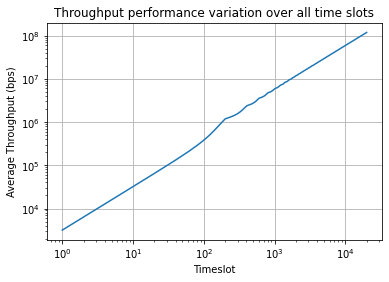

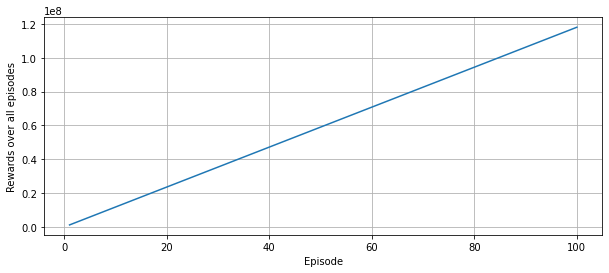

In [30]:
#timeslot = np.arange(start=1,stop=20001,step=1)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,rewards_all_steps) # reward over all time slots
ax1.set_xlabel(r'Timeslot')
#plt.xlim(19800,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Throughput performance variation over all time slots')
plt.grid(True)

episode_ = list(range(1,101))

plt.figure(figsize=(10, 4))
plt.plot(episode_,rewards_all_episodes)
plt.xlabel('Episode')
#plt.xlim(0,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
plt.ylabel(r'Rewards over all episodes')
plt.grid(True)
plt.show()

## Plots ##

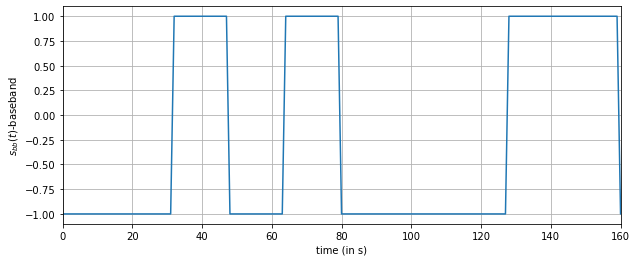

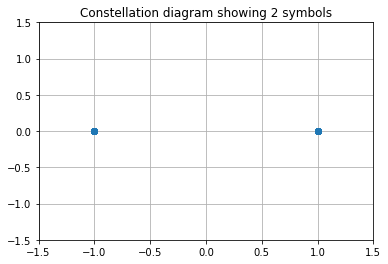

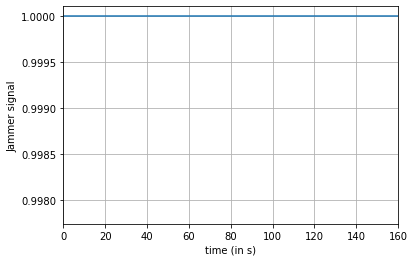

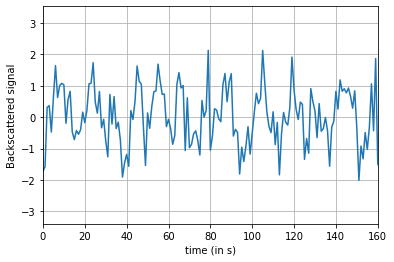

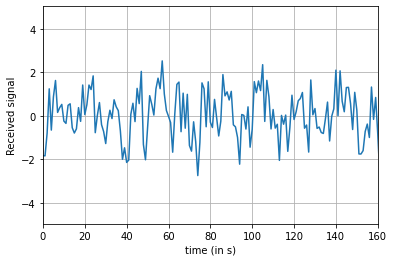

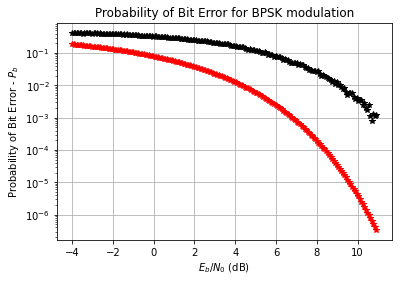

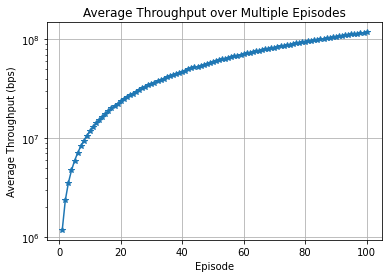

In [75]:
#plotting the baseband signal
plt.figure(figsize=(10, 4))
plt.plot(t,s_bb) # baseband wfm zoomed to first 10 bits
plt.xlabel('time (in s)')
plt.xlim(0,10*L);
plt.ylabel(r'$s_{bb}(t)$-baseband')
plt.grid(True)
plt.show()

#signal constellation at transmitter
plt.plot(np.real(s_bb),np.imag(s_bb),'o')
plt.xlim(-1.5,1.5) 
plt.ylim(-1.5,1.5)
plt.title('Constellation diagram showing 2 symbols')
plt.grid(True)
plt.show()

#plotting the jammer signal
plt.plot(t,Jammer(f_k,1)) # transmitted wfm zoomed to first 10 bits #Plot jammer only when jammer is present, so K_J = 1
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Jammer signal')
plt.grid(True)
plt.show()

#plotting the bandpass signal
plt.plot(t,s_BD) # transmitted wfm zoomed to first 10 bits
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Backscattered signal')
plt.grid(True)
plt.show()

# Received signal waveform zoomed to first 10 bits
plt.plot(t,y_AP) # received signal (with noise)
plt.xlabel('time (in s)')
plt.ylabel('Received signal')
plt.xlim(0,10*L)
plt.grid(True)
plt.show()

EbN0dB_per_episode = np.arange(start=-4,stop = 11,step = (11+4)/(num_episodes))
#------Theoretical Bit/Symbol Error Rates-------------
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # BER = (1/2)*erfc(sqrt(Eb/N0)) = Q(sqrt(2Eb/N0))
#-------------Plots---------------------------
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax1.semilogy(EbN0dB,theoreticalBER,'r*',label='Theoretical')
ax1.set_xlabel(r'$E_b/N_0$ (dB)')
ax1.set_ylabel(r'Probability of Bit Error - $P_b$')
ax1.set_title('Probability of Bit Error for BPSK modulation')
plt.grid(True)

episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,rewards_all_episodes,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

#fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
#ax1.semilogy(step,E_B,'k*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_xlabel(r'Time Slot')
#ax1.set_ylabel(r'E_B - $units$')
#ax1.set_title('BD Battery State over all time slots')
#plt.grid(True)

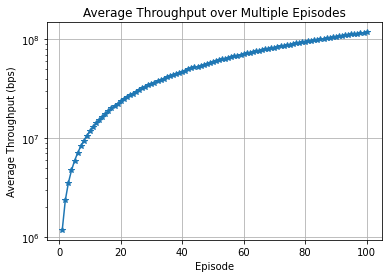

In [34]:
#Plotting average throughput over 100 episodes
episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,rewards_all_episodes,'-*',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
#ax1.set_yscale('log', base=2)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

plt.savefig('avg_throughput_all_episodes.png')

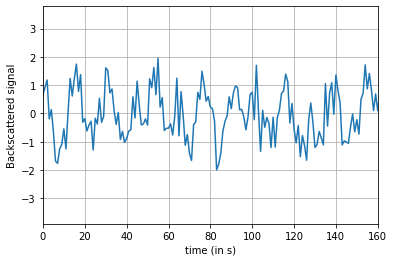

<Figure size 432x288 with 0 Axes>

In [273]:
#plotting the bandpass signal
plt.plot(t,s_BD) # transmitted wfm zoomed to first 10 bits
plt.xlabel('time (in s)') 
plt.xlim(0,10*L)
plt.ylabel('Backscattered signal')
plt.grid(True)
plt.show()

plt.savefig('backscattered_signal.png')


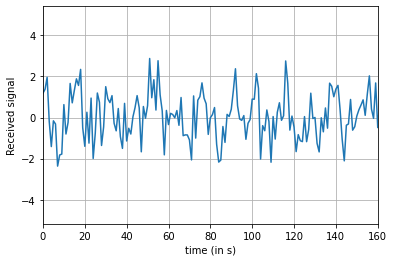

<Figure size 432x288 with 0 Axes>

In [274]:
# Received signal waveform zoomed to first 10 bits
plt.plot(t,y_AP) # received signal (with noise)
plt.xlabel('time (in s)')
plt.ylabel('Received signal')
plt.xlim(0,10*L)
plt.grid(True)
plt.show()

plt.savefig('received_signal.png')

In [115]:
rewards_all_steps_modified = rewards_all_steps*0.00159
print(rewards_all_steps)

[3439.254418423715, 6934.384324572803, 10387.083695276327, 13570.358659834841, 17108.989105847693, 20622.229766494365, 23804.896076599623, 27349.19892736895, 30557.82762596508, 33775.70966676102, 37410.10598568918, 40702.49285710953, 43951.087674210255, 47635.08960443828, 50882.53724418908, 54522.490745009054, 57800.98077110942, 61552.039817135046, 64823.95568164079, 68564.33947773531, 71849.5105212812, 75650.52604562136, 78942.48510953317, 82826.23568295644, 86751.8665052869, 90652.57259089581, 93972.30254863854, 97985.1618858395, 101298.57648249871, 105301.41238047021, 108671.64396942564, 112747.78649707798, 116727.16529805107, 120115.6331786862, 124236.85586437891, 127669.48107704427, 131891.34516661963, 135357.1632186826, 139610.9629182858, 143897.19586076605, 147362.43876568924, 150872.02575858025, 154368.94902784043, 158766.56764511135, 162320.40396368812, 165896.87234274144, 170413.89562703282, 174854.03593021524, 179483.11375878545, 183163.49880867716, 187836.8120415577, 191493

In [117]:
#rewards_all_steps_modified = rewards_all_steps*0.00159
print(np.shape(rewards_all_steps))

(186,)


ValueError: x and y must have same first dimension, but have shapes (187,) and (186,)

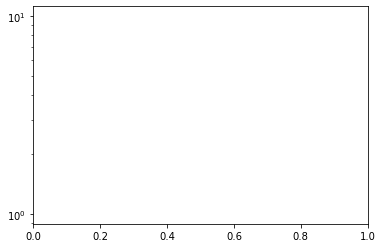

In [118]:
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,rewards_all_steps,'-*') # reward over all time slots
ax1.set_xlabel(r'Timeslot')
#plt.xlim(19800,20000);
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.set_ylabel(r'Average Throughput (bps)')
ax1.set_title('Throughput performance variation over all time slots')
plt.grid(True)

plt.savefig('avg_throughput_all_timeslots.png')

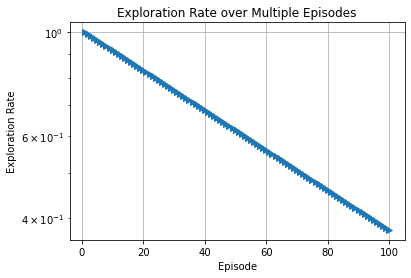

In [287]:
#Plotting exploration rate over 100 episodes
episode_ = np.arange(start = 1,stop=101, step =1)
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(episode_,all_exploration_rate,'->',label='Simulated') # simulated BER
#ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
ax1.set_yscale('log', base=10)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Exploration Rate')
ax1.set_title('Exploration Rate over Multiple Episodes')
plt.grid(True)

plt.savefig('exploration_rate.png')

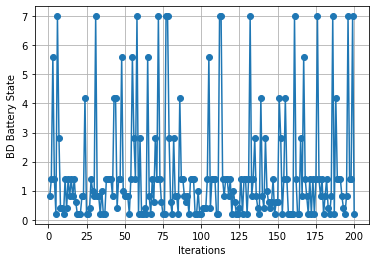

<Figure size 432x288 with 0 Axes>

In [114]:
#Plotting BD battery state over 100 episodes
episode_ = np.arange(start = 1,stop=201, step =1)
#fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
#ax1.semilogy(episode_,E_B,'o-',label='Simulated') 
#ax1.set_yscale('log', base=2)
#ax1.set_xlabel(r'Step')
#ax1.set_ylabel(r'BD Battery State')
#ax1.set_title('Distribution of BD Battery Energy')
#plt.grid(True)

plt.plot(episode_,E_B,'o-') 
plt.xlabel('Iterations')
plt.ylabel('BD Battery State')
#plt.xlim(0,10*L)
plt.grid(True)
plt.show()

plt.savefig('bd_bat_energy.png')

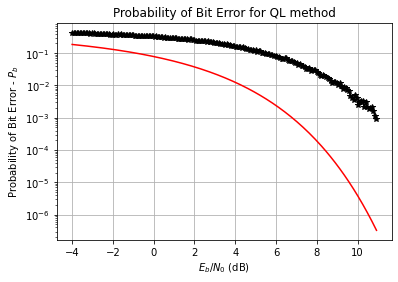

In [320]:
EbN0dB_per_episode = np.arange(start=-4,stop = 11,step = 2)
#------Theoretical Bit/Symbol Error Rates-------------
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB_per_episode/10))) # BER = (1/2)*erfc(sqrt(Eb/N0)) = Q(sqrt(2Eb/N0))
#-------------Plots---------------------------
fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(EbN0dB_per_episode,BER,'k-*',label='Simulated') # simulated BER
ax1.semilogy(EbN0dB_per_episode,theoreticalBER,'r-',label='Theoretical')
ax1.set_xlabel(r'$E_b/N_0$ (dB)')
ax1.set_ylabel(r'Probability of Bit Error - $P_b$')
ax1.set_title('Probability of Bit Error for QL method')
plt.grid(True)

#plt.savefig('BER_Qlearning.png')

In [99]:
M=5
k = np.random.randint(low=1,high=M,dtype = int)
#k = [1,2,3,4]
g = [6,4.5,3,1.5]
h_k = g[k-1]*1e-1
print(h_k)

0.45
